### Import Libraries

In [1]:
import ROOT
from ROOT import TCanvas, TGraphErrors, TGraph
import numpy as np
import time
import math
from array import array
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

Welcome to JupyROOT 6.22/02


### Variables

In [13]:
#Threshold on Voltage defining/limiting the number of counts

#Beginning Threshold in mV:
threshold = 5 #mV
#Range of Thresholds in mV:
thresholdrange = 45 #mV
#Steps of Threshold:
thresholdsteps =  10

#Voltage of Partical Signal (mpv: most probable value):''
#start Value mpv in mV
mpv_start = 100 #mV
#mpv range in mV
mpv_range = 0
#mpv steps
mpv_steps = 1

#Number of Bunch crossing:
bunch_crossings = 1000
#Number of expected particle collisions in one bunch crossing (BC):
mu = 200

#Time of Timewindows
Small_time_Window = 3.125
Large_time_Window = 3 * Small_time_Window

#Number of channels in total and number of modules, detectordependent:

#Total number of channels
nr_of_channels = int(3.6 * 1e6)
#Channels in one modul
channels_per_module = int(15*30)
#Total number of channels given by the ratio between total channels and channels per module
total_modules = int(nr_of_channels/channels_per_module)


### Constants of the Simulation

In [14]:
#Average number of Events in the detector (defined by mu):
expected_count = (15*1e3/200)*mu # 15000 events with mu = 200, Scaling leads to this formula
#?
ratio_of_channels_to_sample = 1
#Threshold defined for while loop (goes from threshold to threshold + thresholdrange)
threshold_While_Loop = threshold 
#Global counter, to give different seeds to random numbers
global_counter = 0
#"real" number of channels
channel_count = nr_of_channels*ratio_of_channels_to_sample
#Events in the detector are equivalent to particales reaching the different layers
avg_particles_reaching_detector = expected_count #15000 for mu=200
#Create Histogramms to collect data
countHistos = {}
#Mean value of evry simulation
mean__diff_sim = 0
#array of thresholds, used for loop
thresholds_array = np.linspace(threshold,threshold + thresholdrange,thresholdsteps)
print(thresholds_array)
#array of mpv, used for loop
mpv_array = np.linspace(mpv_start,mpv_start + mpv_range,mpv_steps)
print(mpv_array)

[ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50.]
[100.]


### Simulation and Definition of Functions

In [15]:
#Noise generator. Defined by Gaus dis. around zero and the threshold
Start_time = time.time()
class noise_generator:
    def __init__(self, threshold, channel_count): 
        global global_counter
        low = 0
        high = 1000
        noise = ROOT.TF1("noise_gauss", "TMath::Gaus(x, 0, 5)", low, high)
        
        """Why divide with 2?? Why do we need a avg. value?"""
        #integrate normal dist. to get exact prob. above threshold and multiply with channel nr to get avg.
        self._mean = channel_count * noise.Integral(threshold, high)/noise.Integral(low, high) 
        #self._prng = ROOT.TRandom3(time.time_ns())
        global_counter += 1
        self._prng = ROOT.TRandom3(int(time.time()) + global_counter)

    def generate(self):
        """The first return value is the exact number of noise activated channels in the small window and
            the second return value is the estimated number of noise activated channels in the small window. (estimated from large window)
            (both results are in small window, both results are noise above threshold)
            noise_exact, noise_est = noise.generate()"""
        # Large time window 25ns
        # Small time window 3.125ns
        prng = self._prng
        total = prng.Poisson(self._mean) # number of noise above threshold in large window in this run.
        narrow_exact = 0
        narrow_exact = (np.random.rand(total) < (Small_time_Window/Large_time_Window)).sum()  # exact value of noise activated channels 
        #in the small window3.125/25 = 0.125
        
        noise_per_time = (total - narrow_exact)/(Large_time_Window - Small_time_Window) #noise per time in the large window
        estimate = 3.125 * noise_per_time #noise we would expect in the small window
        return narrow_exact, estimate
    
    
    
    
#Signal generator. Defined by Landau dis. around mpv voltage and the threshold

class signal_generator:
    def __init__(self, threshold, real_expected_voltage, guess_expected_voltage): # expected_voltage = expected peak voltage  (mu)
        global global_counter
        low = -100
        high = 1000
        self._threshold = threshold
        self._expected_voltage = real_expected_voltage
        signal_func = ROOT.TF1("sth", "TMath::Landau(x, %f, %f)" % (guess_expected_voltage, guess_expected_voltage/4), low, high)
        self.fraction_above = signal_func.Integral(threshold, high)/signal_func.Integral(low, high) #fraction of the function that is above threshold
        #self._prng = ROOT.TRandom3(time.time_ns())
        global_counter += 1
        self._prng = ROOT.TRandom3(int(time.time()) + global_counter)
    
    def generate(self, expected_count):
        """The paramater is the expected number of particles that reach the detector.
            The first return value is the number of particles that reached the detector and
            the second return value is the number of activated channels.
            signal_real_total, signal_above = signal.generate(30)"""
        prng = self._prng
        expected_voltage = self._expected_voltage
        threshold = self._threshold
        
        signal_count = prng.Poisson(expected_count)
        above_threshold_count = 0
        sigma = expected_voltage/4
        for i in range(signal_count):
            if prng.Landau(expected_voltage, sigma) > threshold: # 1/4 is just the refernce 25/100
                above_threshold_count += 1
        return signal_count, above_threshold_count
    
    


for k in mpv_array:
    #Real Voltage value in mV:
    peak_mpv_voltage = k #mV
    #Guessed Voltage value in mV:
    guess_mpv = k #mV
    print("mpv: %d" % (k))
    for i in thresholds_array:
        print("threshold: %s" %i)
        #create Histo for different thrsholds
        countHistos["mpv_"+str(k)+"mV_threshold_"+str(i)+"_mV"] = ROOT.TH1F("threshold: %s mV" % i, "; difference estimate and real [counts]; Number of events", 900, -45, 45)

        #generate the noise
        noise_gen = noise_generator(i, channel_count)
        #generate the signal
        signal_gen = signal_generator(i, peak_mpv_voltage, guess_mpv)

        #actual counts in the small window preparation
        result_actual_signal_count = np.zeros(bunch_crossings)
        #estimated counts in the small window preparation
        result_estimated_signal_count = np.zeros(bunch_crossings)
        #using the probability distribution, the percentage we expact to not cut off by the threshold
        signal_fraction_above = signal_gen.fraction_above


        for BC in range(bunch_crossings):
            # both results are in small window, both are noise above threshold, first exact, second estimated
            noise_exact, noise_est = noise_gen.generate()

            # The first return value is the number of particles that reached the detector and 
            # the second return value is the number of activated channels (after the threshold!).
            total_actual_signal, signal_above = signal_gen.generate(avg_particles_reaching_detector)

            # from the total activations, estimate how much was produced by actual signal
            total_activations = signal_above + noise_exact  # total activations in small window (i.e. above threshold)
            #just to get a feeling how long one threshold simulation takes (and to check if everything works)
            if BC == bunch_crossings-1 :
                    print("Bunch Crossing: %d" %(BC+1))
                    print("--------------")
            #total real activations minus estimation of signal, then divide with the prob. mass for Landau to be above threshold
            total_signal_est = (total_activations - noise_est)/signal_fraction_above 

            # assign the results
            result_actual_signal_count[BC] = total_actual_signal #exact count in the small window
            result_estimated_signal_count[BC] = total_signal_est #estimated count in the smalll window

            #add difference between the real and estimated value to a Histogram 
            countHistos["mpv_"+str(k)+"mV_threshold_"+str(i)+"_mV"].Fill((result_estimated_signal_count[BC]-result_actual_signal_count[BC])/total_actual_signal)
    print("--------------------------------------------------------")
    print("Cpu time: %s" % (time.time()-Start_time))
#time for simulation in total
print("Cpu time: %s" % (time.time()-Start_time))

mpv: 100
threshold: 5.0
Bunch Crossing: 1000
--------------
threshold: 10.0
Bunch Crossing: 1000
--------------
threshold: 15.0
Bunch Crossing: 1000
--------------
threshold: 20.0
Bunch Crossing: 1000
--------------
threshold: 25.0
Bunch Crossing: 1000
--------------
threshold: 30.0
Bunch Crossing: 1000
--------------
threshold: 35.0
Bunch Crossing: 1000
--------------
threshold: 40.0
Bunch Crossing: 1000
--------------
threshold: 45.0
Bunch Crossing: 1000
--------------
threshold: 50.0
Bunch Crossing: 1000
--------------
--------------------------------------------------------
Cpu time: 87.87043857574463
Cpu time: 87.87060475349426


## Evaluation of data

### Variable MPV and Threshold - Plot preperation

##### Just mean values (evaluate this before plotting to get just the mean values)

In [6]:
arr=[]
for k in mpv_array:
    col = []
    for i in thresholds_array:
        col.append(countHistos["mpv_"+str(k)+"mV_threshold_"+str(i)+"_mV"].GetMean())
    arr.append(col)

Plot_array_X = np.array(thresholds_array)    
Plot_array_Y = np.array(mpv_array)
Plot_array_Z = np.array(arr)

def Value_of_Dev(MPV,TH):
    Position_MPV = [i for i, x in enumerate(mpv_array) if x == MPV]
    Position_TH = [i for i, x in enumerate(thresholds_array) if x == TH]
    Value_of_interest = arr[Position_MPV[0]][Position_MPV[0]]
    return(Value_of_interest)


X, Y = np.meshgrid(Plot_array_X, Plot_array_Y)
Z = Plot_array_Z

#### Max deviation (absolute mean value plus half stand div (error bar))

In [59]:
arr=[]
for i in thresholds_array:
    col = []
    for k in mpv_array:
        col.append(abs(countHistos["mpv_"+str(k)+"mV_threshold_"+str(i)+"_mV"].GetMean())+abs(countHistos["mpv_"+str(k)+"mV_threshold_"+str(i)+"_mV"].GetStdDev()))
    arr.append(col)

Plot_array_Y = np.array(thresholds_array)    
Plot_array_X = np.array(mpv_array)
Plot_array_Z = np.array(arr)

def Value_of_Dev(MPV,TH):
    Position_MPV = [i for i, x in enumerate(mpv_array) if x == MPV]
    Position_TH = [i for i, x in enumerate(thresholds_array) if x == TH]
    Value_of_interest = arr[Position_MPV[0]][Position_MPV[0]]
    return(Value_of_interest)
Value_of_Dev(25,20)


X, Y = np.meshgrid(Plot_array_X, Plot_array_Y)
Z = Plot_array_Z

### Plot itself

#### 2D Contour Plot

TypeError: Input z must be at least a (2, 2) shaped array, but has shape (1, 5)

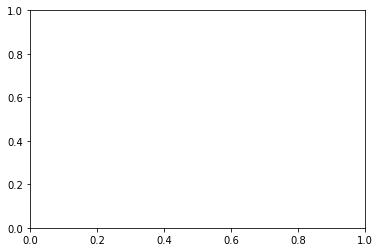

In [7]:
plt.contour(X, Y, Z, 30, cmap='RdGy');
plt.colorbar();

#### 3D Data plot

In [8]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)
ax.set_title("mpv:(%d,%d),TH:(%d,%d)" % (mpv_start,mpv_start+mpv_range,threshold,threshold+thresholdrange), fontsize=40)
ax.set_xlabel('MPV in mV', fontsize=20)
ax.set_ylabel('Threshold in mV', fontsize=20)
ax.set_zlabel('Deviation', fontsize=20)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f')),
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.zaxis.set_tick_params(labelsize=12)

fig.colorbar(surf, shrink=0.5, aspect=5)


plt.savefig('3D_mpv_threshold.pdf')

ValueError: not enough values to unpack (expected 5, got 0)

ValueError: not enough values to unpack (expected 5, got 0)

<Figure size 864x864 with 2 Axes>

### Constant Threshold variable MPV

#### Mean values

#### Absolute maximal deviation

### Constant MPV variable threshold

#### Mean values

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Deviation over Threshold
Info in <TCanvas::Print>: pdf file Deviation_Over_Threshold.pdf has been created


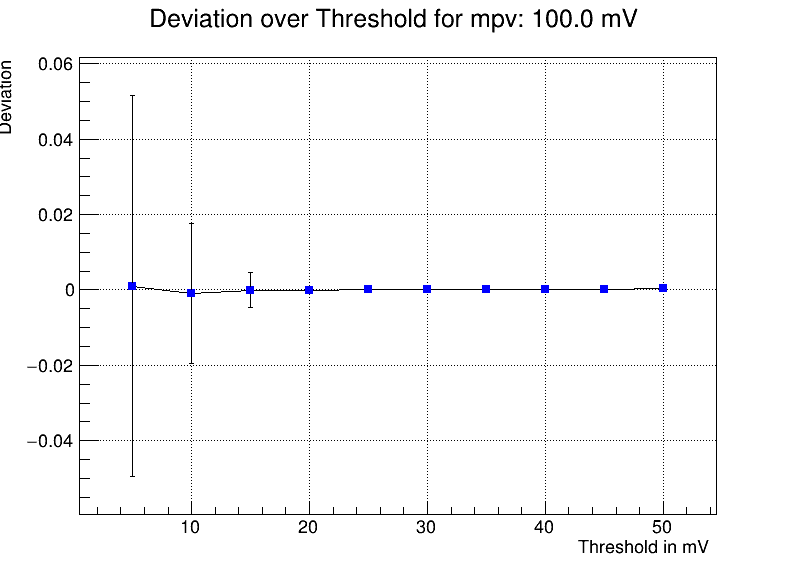

In [20]:
#choose mpv you want to look for
Const_mpv = 100.0
#arrays for mean values and deviations
Mean_TH_Array = []
Std_Div_TH_Array = []
threshold_deviation_array = []

#add the mean values of every threshold
for i in thresholds_array:
    Mean_Histo = (countHistos["mpv_"+str(Const_mpv)+"mV_threshold_"+str(i)+"_mV"].GetMean())#mean value of diviation
    MStd_Div_Histo = abs(countHistos["mpv_"+str(Const_mpv)+"mV_threshold_"+str(i)+"_mV"].GetStdDev()) # std div of this distribution
    Mean_TH_Array.append(Mean_Histo) #mean value
    Std_Div_TH_Array.append(MStd_Div_Histo) #error on mean value
    threshold_deviation_array.append(0) # error on threshold. Could create "bin" using (thresholdrange/(thresholdsteps-1)
    

#create x,y values and corresponding errors

n = len(thresholds_array);
x  = array( 'f', thresholds_array )
ex = array( 'f', threshold_deviation_array )
y  = array( 'f', Mean_TH_Array )
ey = array( 'f', Std_Div_TH_Array ) 
muHistoAll = TGraphErrors( n, x, y, ex, ey )


#create Canvas
CanvasMu = ROOT.TCanvas("Deviation over Threshold", "Difference in counts", 800, 600)
CanvasMu.SetGrid()

    
#Set different plot settings 
muHistoAll.SetTitle( 'Deviation over Threshold for mpv: %s mV ' % peak_mpv_voltage)
muHistoAll.SetMarkerColor( 4 )
muHistoAll.SetMarkerStyle( 21 )
muHistoAll.GetXaxis().SetTitle( 'Threshold in mV' )
muHistoAll.GetYaxis().SetTitle( 'Deviation' )
muHistoAll.Draw( 'ALP' )

#Draw and export final Histo
CanvasMu.Draw()
CanvasMu.GetFrame().SetBorderSize( 12 )
CanvasMu.Modified()
CanvasMu.Update()
CanvasMu.SaveAs("Deviation_Over_Threshold.pdf")

#### Finding the best threshold (maybe you have some ideas how to implement it in the section above)

The minimum deviation is 0.000103 at a threshold of 25 mV


Warning in <TCanvas::Constructor>: Deleting canvas with same name: Deviation over Threshold
Info in <TCanvas::Print>: pdf file Maximum_Deviation_Over_Threshold.pdf has been created


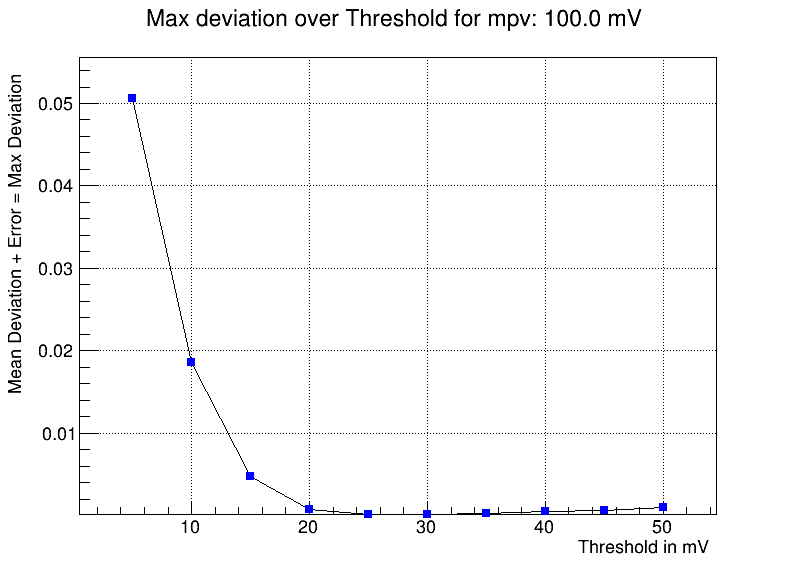

In [22]:
#choose mpv you want to look for
Const_mpv = 100.0
#create absolute mean values
Total_Array_TH_Absolute = []

for i in thresholds_array:
    Mean_Histo_Absolute = abs(countHistos["mpv_"+str(Const_mpv)+"mV_threshold_"+str(i)+"_mV"].GetMean())#mean absolute value of diviation
    MStd_Div_Histo_Absolute = abs(countHistos["mpv_"+str(Const_mpv)+"mV_threshold_"+str(i)+"_mV"].GetStdDev()) # std div of this distribution
    Total_Array_TH_Absolute.append((MStd_Div_Histo_Absolute)) #appending it to the array

#Minimum values 
Minimum = min(Total_Array_TH_Absolute)#minimum deviation
mymin = np.min(Total_Array_TH_Absolute)#used for min threshold calculation
MinimumBin_List = [i for i, x in enumerate(Total_Array_TH_Absolute) if x == mymin]#list of postions of minimum thresholds
MinimumBin = thresholds_array[MinimumBin_List[0]]#calculating the actual minimum threshold
print("The minimum deviation is %f at a threshold of %d mV" % (Minimum,MinimumBin))

#set up histo
n_Graph = len(thresholds_array);
x_Graph = array( 'f', thresholds_array )
y_Graph = array( 'f', Total_Array_TH_Absolute )

MinimalHistoAll={}
MinimalHistoAll = TGraphErrors( n_Graph, x_Graph, y_Graph)

#create Canvas
CanvasMinimal = ROOT.TCanvas("Deviation over Threshold", "Difference in counts", 800, 600)
CanvasMinimal.SetGrid()

#Set different plot settings 
MinimalHistoAll.SetTitle( 'Max deviation over Threshold for mpv: %s mV ' % peak_mpv_voltage)
MinimalHistoAll.SetMarkerColor( 4 )
MinimalHistoAll.SetMarkerStyle( 21 )
MinimalHistoAll.GetXaxis().SetTitle( 'Threshold in mV' )
MinimalHistoAll.GetYaxis().SetTitle( 'Mean Deviation + Error = Max Deviation' )
MinimalHistoAll.Draw( 'ALP' )



#Draw and export final Histo
CanvasMinimal.Draw()
CanvasMinimal.GetFrame().SetBorderSize( 12 )
CanvasMinimal.Modified()
CanvasMinimal.Update()
CanvasMinimal.SaveAs("Maximum_Deviation_Over_Threshold.pdf")

### Possibility to check every distribution for every threshold ( and later also mpv)

In [23]:

Canvas = ROOT.TCanvas("Difference in counts", "Events", 800, 600)

threshold_Draw = 100.0
countHistos["mpv_"+str(k)+"mV_threshold_"+str(i)+"_mV"].SetMarkerStyle(20)
countHistos["mpv_"+str(k)+"mV_threshold_"+str(i)+"_mV"].SetLineColor(ROOT.kAzure-9)
countHistos[str(threshold_Draw)+"_mV"].SetFillColor(ROOT.kAzure-14)
countHistos[str(threshold_Draw)+"_mV"].Draw()
Canvas.Draw()
#Canvas.SaveAs(str(threshold_Draw)+"_mV.pdf")
#print("Histogram exported as " +str(threshold_Draw)+"_mV.pdf")

KeyError: '100.0_mV'